# Building an interactive Custom Visualization

---
This notebook is my answer to the third assignment of the [Applied Plotting, Charting & Data Representation in Python](https://www.coursera.org/learn/python-plotting?specialization=data-science-python#about) course offered by the University of Michigan on Coursera.

---

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Ferreira, N., Fisher, D., & Konig, A. C. (2014, April). [Sample-oriented task-driven visualizations: allowing users to make better, more confident decisions.](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/Ferreira_Fisher_Sample_Oriented_Tasks.pdf) 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In Proceedings of the SIGCHI Conference on Human Factors in Computing Systems (pp. 571-580). ACM. ([video](https://www.youtube.com/watch?v=BI7GAs-va-Q))


In this [paper](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/Ferreira_Fisher_Sample_Oriented_Tasks.pdf) the authors describe the challenges users face when trying to make judgements about probabilistic data generated through samples. As an example, they look at a bar chart of four years of data (replicated below in Figure 1). Each year has a y-axis value, which is derived from a sample of a larger dataset. For instance, the first value might be the number votes in a given district or riding for 1992, with the average being around 33,000. On top of this is plotted the 95% confidence interval for the mean (see the boxplot lectures for more information, and the yerr parameter of barcharts).

<br>
<img src="Assignment3Fig1.png" alt="Figure 1" style="width: 400px;"/>
<h4 style="text-align: center;" markdown="1">  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Figure 1 from (Ferreira et al, 2014).</h4>

<br>

A challenge that users face is that, for a given y-axis value (e.g. 42,000), it is difficult to know which x-axis values are most likely to be representative, because the confidence levels overlap and their distributions are different (the lengths of the confidence interval bars are unequal). One of the solutions the authors propose for this problem (Figure 2c) is to allow users to interactively set a range of y values they are interested in (e.g. \[42,000, 50000\] ), then draw a shaded area corresponding to this range and recolor bars based on their probabilities to get values belonging to this range.


<br>
<img src="Assignment3Fig2.png" alt="Figure 1" style="width: 400px;"/>
<h4 style="text-align: center;" markdown="1">  Figure 2d from (Ferreira et al. 2014).</h4>

<br>
<br>

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

The goal of this assignment is to build the kind of interactive visualition seen above. Hence, data can then be anything. Knowing that, I am generating some data using numpy.random

In [49]:
np.random.seed(12345)

df = pd.DataFrame([np.random.normal(32000,200000,3650), 
                   np.random.normal(43000,100000,3650), 
                   np.random.normal(43500,140000,3650), 
                   np.random.normal(48000,70000,3650)], 
                  index=[1992,1993,1994,1995])

Now I will find the 95% confidence intervals of these four distributions using the formula :
    

In [50]:
conf_ymin = [df.loc[item].mean() - 1.96 * (df.loc[item].std()) / (3650**0.5) for item in df.index]
conf_ymax = [df.loc[item].mean() + 1.96 * (df.loc[item].std()) / (3650**0.5) for item in df.index]

### Functions I created to generate such an interactive graph

In [16]:
def reset_plot():
    
    global bar
    '''
    Reset the bar plot with grey colors.
    x values are the year.
    y values are the mean of values for each year (df.mean(axis=1)).
    After plotting, will do some formatting.
    '''
    
    plt.cla()    #Clear the plot reset the color
    
    # Plot bars with the 95% confidence intervals
    bar = plt.bar(df.index, df.mean(axis=1),
                  width=1, edgecolor='k',
                  yerr=1.96 * (df.std(axis=1)) / (3650**0.5),
                  capsize=13,
                  color='silver')

    #Formatting
    
    plt.axis([1990, 1997, 0, 55000])
    plt.xticks([1992, 1993, 1994, 1995])
    plt.gca().spines['left'].set_position(('outward',-60))
    plt.gca().spines['right'].set_visible(False)
    plt.ylabel('Mean')
    plt.xlabel('Year')
    plt.title('Compare each bar to a range')

In [81]:
def color (mean_y, bar_to_color):
    
    '''
    Colors a bar depending on the difference between the mean value found by 'lines' function 
    and the center of the confidence interval.
    Computes this difference and divide it by the maximum deviation allowed.
    
    Args :
        mean_y - mean value found by 'lines'.
        bar_to_color - the bar of the barplot to color.
    '''
    
    # Compute the difference
    dist = np.abs(mean_y - df.iloc[bar_to_color].mean())
    
    # Maximum deviation
    mean_std = 1.96 * (df.iloc[bar_to_color].std()) / (3650**0.5)
    
    # Relative distance
    rel_dist = dist / mean_std
    
    
    # Set a color depending on the interval the relative distance in in
    zipper = zip([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
                 ['firebrick', 'indianred', 'tomato', 'coral', 'salmon',
                  'lightsalmon', 'sandybrown', 'navajowhite', 'mocassin', 'papayawhip'])
    
    for lim, color in zipper:
        
        if rel_dist == 0:
            bar[bar_to_color].set_color('darkred')
            
        if rel_dist > 1:
            bar[bar_to_color].set_color('floralwhite')   
            
        if (rel_dist > lim) & (rel_dist <= (lim + 0.1)):
            bar[bar_to_color].set_color(color)

In [78]:
def lines(event):
    
    '''
    Is launched each time the user clicks on the graph.
    Draws lines in the bar plot.
    Each line is a horizontal one with y =  the y coordinate of the point where the user clicked
    
    Args : event - This object will give us the y coordinate of where the user clicked with the attribute .ydata
    '''
    global check, y1, y2, bar
    
    
    # Check if there is no line drawn or two lines drawn. If so, the following code will draw a new first line
    # If there is just one line drawn, check = 1, and then it moves to the 'else' section to plot the second line
    
    if check == 0: # Draw a line corresponding to the first value of the range
        
        # Reset the plot
        reset_plot()
        
        # Draw the first line according to event.ydata, the y coordinate of where the user clicked
        plt.gca().axhline(event.ydata, color='slategrey', linewidth=1.3)
        
        # The small rectangle where the ycoordinate will be displayed
        rect = plt.Rectangle((1990, event.ydata), 1,2000 , color='slategrey', alpha=1)
        plt.gca().add_patch(rect)
        plt.text(1990.2, event.ydata+600, round(event.ydata, 2), color='w', fontsize=8)
        
        # Specify that a first line have been drawn for the next click with check=1
        check = 1
        
        # Store the coordinate this first line to associate proper colors to bars later
        y1 = event.ydata
        
        
    else: # Draw the second line and change the colors of the bars
        
        # Draw the second line according to event.ydata, the y-coordinate of where the user clicked
        plt.gca().axhline(event.ydata, color='slategrey', linewidth=1.3)
        
        rect = plt.Rectangle((1990, event.ydata-2000), 1,2000 , color='slategrey', alpha=1)
        plt.gca().add_patch(rect)
        plt.text(1990.2, event.ydata-1400, round(event.ydata, 2), color='w', fontsize=8)
        
        # Display the shaded area between both lines
        rect2 = plt.Rectangle((1990,event.ydata), 7, y1-event.ydata, color='slategrey', alpha=0.2)
        plt.gca().add_patch(rect2)
        
        # Change the check and store the y_coordinate
        check = 0
        
        y2 = event.ydata
        
        # Define the range of our chosen y_coordinates
        
        if y1 > y2:
            
            ymax = y1
            ymin = y2
            
        elif y1 < y2:
            
            ymax = y2
            ymin = y1
        
        
        for i in range(len(conf_ymax)): #For all bars
            
            # We would like to find the intersection range between the confidence interval and the [y1, y2] interval
            # Then take the mean value of this intersection and give it to the color function
            # If [y1,y2] is outside of the confidence interval, we'll color the bar with 'floralwhite'
            
  
            if (ymax <= conf_ymax[i]) & (ymin >= conf_ymin[i]):
                mean = np.mean([ymax, ymin])
                color(mean,i)
                
            elif (ymax > conf_ymax[i]) & ((ymin >= conf_ymin[i]) & (ymin < conf_ymax[i])):
                mean = np.mean([conf_ymax[i], ymin])
                color(mean,i)
                
            elif ((ymax <= conf_ymax[i]) & (ymax > conf_ymin[i])) & (ymin < conf_ymin[i]):
                mean  = np.mean([ymax, conf_ymin[i]])
                color(mean,i)
                
            elif (ymax > conf_ymax[i]) & (ymin < conf_ymin[i]):
                mean = np.mean([conf_ymax[i], conf_ymin[i]])
                color(mean,i)
                
            else:
                bar[i].set_color('floralwhite')

            bar[i].set_edgecolor('k')


### Connect our functions to an event

<IPython.core.display.Javascript object>


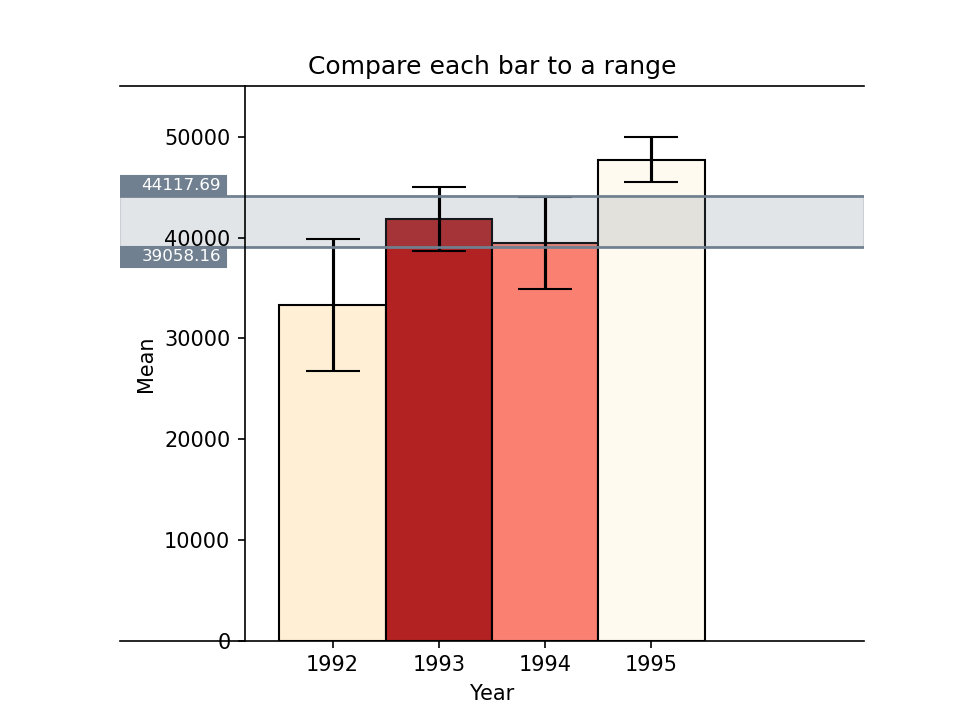

In [80]:
# Create the figure we are continuously going to plot on

plt.figure()

reset_plot()

# Initialize our check value to 0 as there is no line drawn yet
check = 0

# Connect our lines function to the 'button press_event', which will run it every time the user clicks on the plot 
plt.gcf().canvas.mpl_connect('button_press_event', lines);

You can play with the chart now and see what colors will be displayed !